#### Magic Commands
Magic commands (those that start with `%`) are commands that modify a configuration of Jupyter Notebooks. A number of magic commands are available by default (see list [here](http://ipython.readthedocs.io/en/stable/interactive/magics.html))--and many more can be added with extensions. The magic command added in this section allows `matplotlib` to display our plots directly on the browser instead of having to save them on a local file.

In [1]:
%matplotlib inline

# Activity 5: Assembling a Deep Learning System
In this activity, we will train the first version of our LSTM model using Bitcoin daily closing prices. These prices will be organized using the weeks of both 2016 and 2017. We do that because we are interested in predicting the prices of a week's worth of trading.

Let's go ahead and import our data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from keras.models import load_model

D:\Anaconda3\envs\machinelearn\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
plt.style.use('seaborn-white')

### Shaping Data
Neural networks typically work with vectors and tensors, both mathematical objects that organize data in a number of dimensions. 

In [4]:
train = pd.read_csv('data/train_dataset.csv')

In [5]:
train.head()

,date,iso_week,close,volume,close_point_relative_normalization,volume_point_relative_normalization
0,2016-01-01,2016-00,434.33,36278900.0,0.000000,0.000000
1,2016-01-02,2016-00,433.44,30096600.0,-0.002049,-0.170410
2,2016-01-03,2016-01,430.01,39633800.0,0.000000,0.000000
3,2016-01-04,2016-01,433.09,38477500.0,0.007163,-0.029175
4,2016-01-05,2016-01,431.96,34522600.0,0.004535,-0.128961


LSTM networks require vectors with three dimensions. These dimensions are:
    
* **Period length**: The period length, i.e. how many observations is there on a period.
* **Number of periods**: How many periods are available in the dataset.
* **Number of features**: Number of features available in the dataset.

We will create weekly groups then rearrange the resulting array to match those dimensions.

In [7]:
def create_groups(data, group_size=7):
    """
    Creates distinct groups from a given continuous series.
    
    Parameters
    ----------
    data: np.array
        Series of continious observations.

    group_size: int, default 7
        Determines how large the groups are. That is,
        how many observations each group contains.
    
    Returns
    -------
    A Numpy array object. 
    """
    samples = list()
    for i in range(0, len(data), group_size):
        sample = list(data[i:i + group_size])
        if len(sample) == group_size:
            samples.append(np.array(sample).reshape(1, group_size).tolist())
    
    return np.array(samples)

In [8]:
data = create_groups(train['close_point_relative_normalization'].values)

In [9]:
data.shape

(77, 1, 7)

In [10]:
X_train = data[:-1,:].reshape(1, 76, 7)
Y_validation = data[-1].reshape(1, 7)

### Load Our Model
Let's start by loading our previously trained model. 

In [11]:
model = load_model('bitcoin_lstm_v0.h5')

### Make Predictions


In [12]:
%%time
history = model.fit(
    x=X_train, y=Y_validation,
    batch_size=32, epochs=100)

Epoch 1/100
1/1 [==============================] - 1s 596ms/step - loss: 0.0086
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0075
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0068
Epoch 4/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0063
Epoch 5/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0058
Epoch 6/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0054
Epoch 7/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0050
Epoch 8/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0047
Epoch 9/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0044
Epoch 10/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0041
Epoch 11/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0039
Epoch 12/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0036
Epoch 13/100
1/1 [==============================

In [13]:
model.save('bitcoin_lstm_v0_trained.h5')

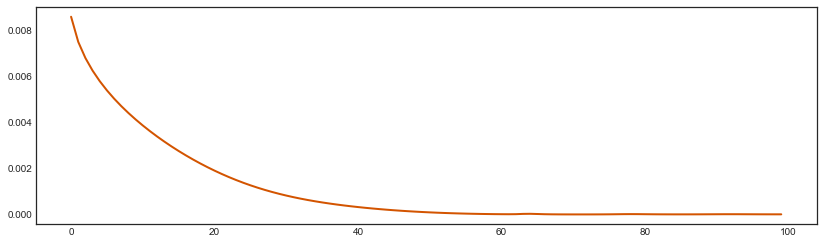

In [14]:
pd.Series(history.history['loss']).plot(linewidth=2, figsize=(14, 4), color='#d35400')

In [15]:
def denormalize(series, last_value):
    result = last_value * (series + 1)
    return result

In [17]:
predictions = model.predict(x=X_train)[0]
predictions

array([-0.148582  , -0.10505424, -0.00186389,  0.01884804,  0.06389655,
        0.05589461,  0.06377069], dtype=float32)

In [18]:
last_weeks_value = train[train['date'] == train['date'].max()]['close'].values[0]
print('last_weeks_value:\t',last_weeks_value)
denormalized_prediction = denormalize(predictions, last_weeks_value)
print('denormalized_prediction:\t',denormalized_prediction)

last_weeks_value:	 2608.72
denormalized_prediction:	 [2221.111  2334.6628 2603.8577 2657.8894 2775.4082 2754.5334 2775.0798]


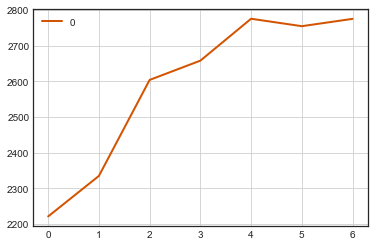

In [19]:
pd.DataFrame(denormalized_prediction).plot(linewidth=2, figsize=(6, 4), color='#d35400', grid=True)

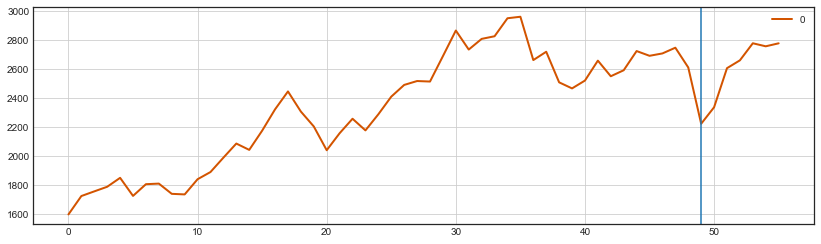

In [20]:
full_series = list(train['close'].values) + list(denormalized_prediction)
pd.DataFrame(full_series[-7*8:]).plot(linewidth=2, figsize=(14, 4), color='#d35400', grid=True)
plt.axvline(len(full_series[-7*8:]) - 7)

### Summary
In this activity, we have assembled a complete deep learning system: from data to prediction. The model created in this activity need a number of improvements before it can be considered useful. However, it serves as a great starting point from which we will continuously improve.